In [1]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

# import gridtools.solps_python_scripts.setup
# from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

SOLEDGE could not be imported
Viewer_2D: SOLEDGE functions not found
Done


# Add core sources and transport barrier

In [11]:
# close_mesh()
old_grid_path = r"C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af6-tunepuff.nc"
new_grid_path = r"C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc"
impose_fields(
    old_grid_path,
    new_grid_path,
    Ni_src_core = 0,    # s-1
    Pi_src_core = 0.3e6 * 2/3 * 0,   # W converted to pressure
    Pe_src_core = 0.3e6 * 2/3 * 0,   # W converted to pressure
    D_core = 4,
    chi_core = 10,
    D_sol = 4,
    chi_sol = 4,
    plot = False
)

>>> Field Nd+_src already exists in C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc, it will be overwritten
-> Wrote field Nd+_src to C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc
>>> Field Pd+_src already exists in C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc, it will be overwritten
-> Wrote field Pd+_src to C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc
>>> Field Pe_src already exists in C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc, it will be overwritten
-> Wrote field Pe_src to C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc
>>> Field D_d+ already exists in C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc, it will be overwritten
-> Wrote field D_d+ to C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc
>>> Field D_e already ex

# Manually add puff and pump
- Puff is at IMP (covering the two cells around the midplane axis)
- Pumps are at all the walls - MAST-U has no cryopump yet and the targets don't saturate


Total particle flow: -1.00e+21 [s-1]
>>> Field Nd_src already exists in C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc, it will be overwritten
-> Wrote field Nd_src to C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc
>>> Field Pd_src already exists in C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc, it will be overwritten
-> Wrote field Pd_src to C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc
>>> Field is_pump already exists in C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc, it will be overwritten
-> Wrote field is_pump to C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc
Mesh file C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af8b-divpump_-6e21.nc closed


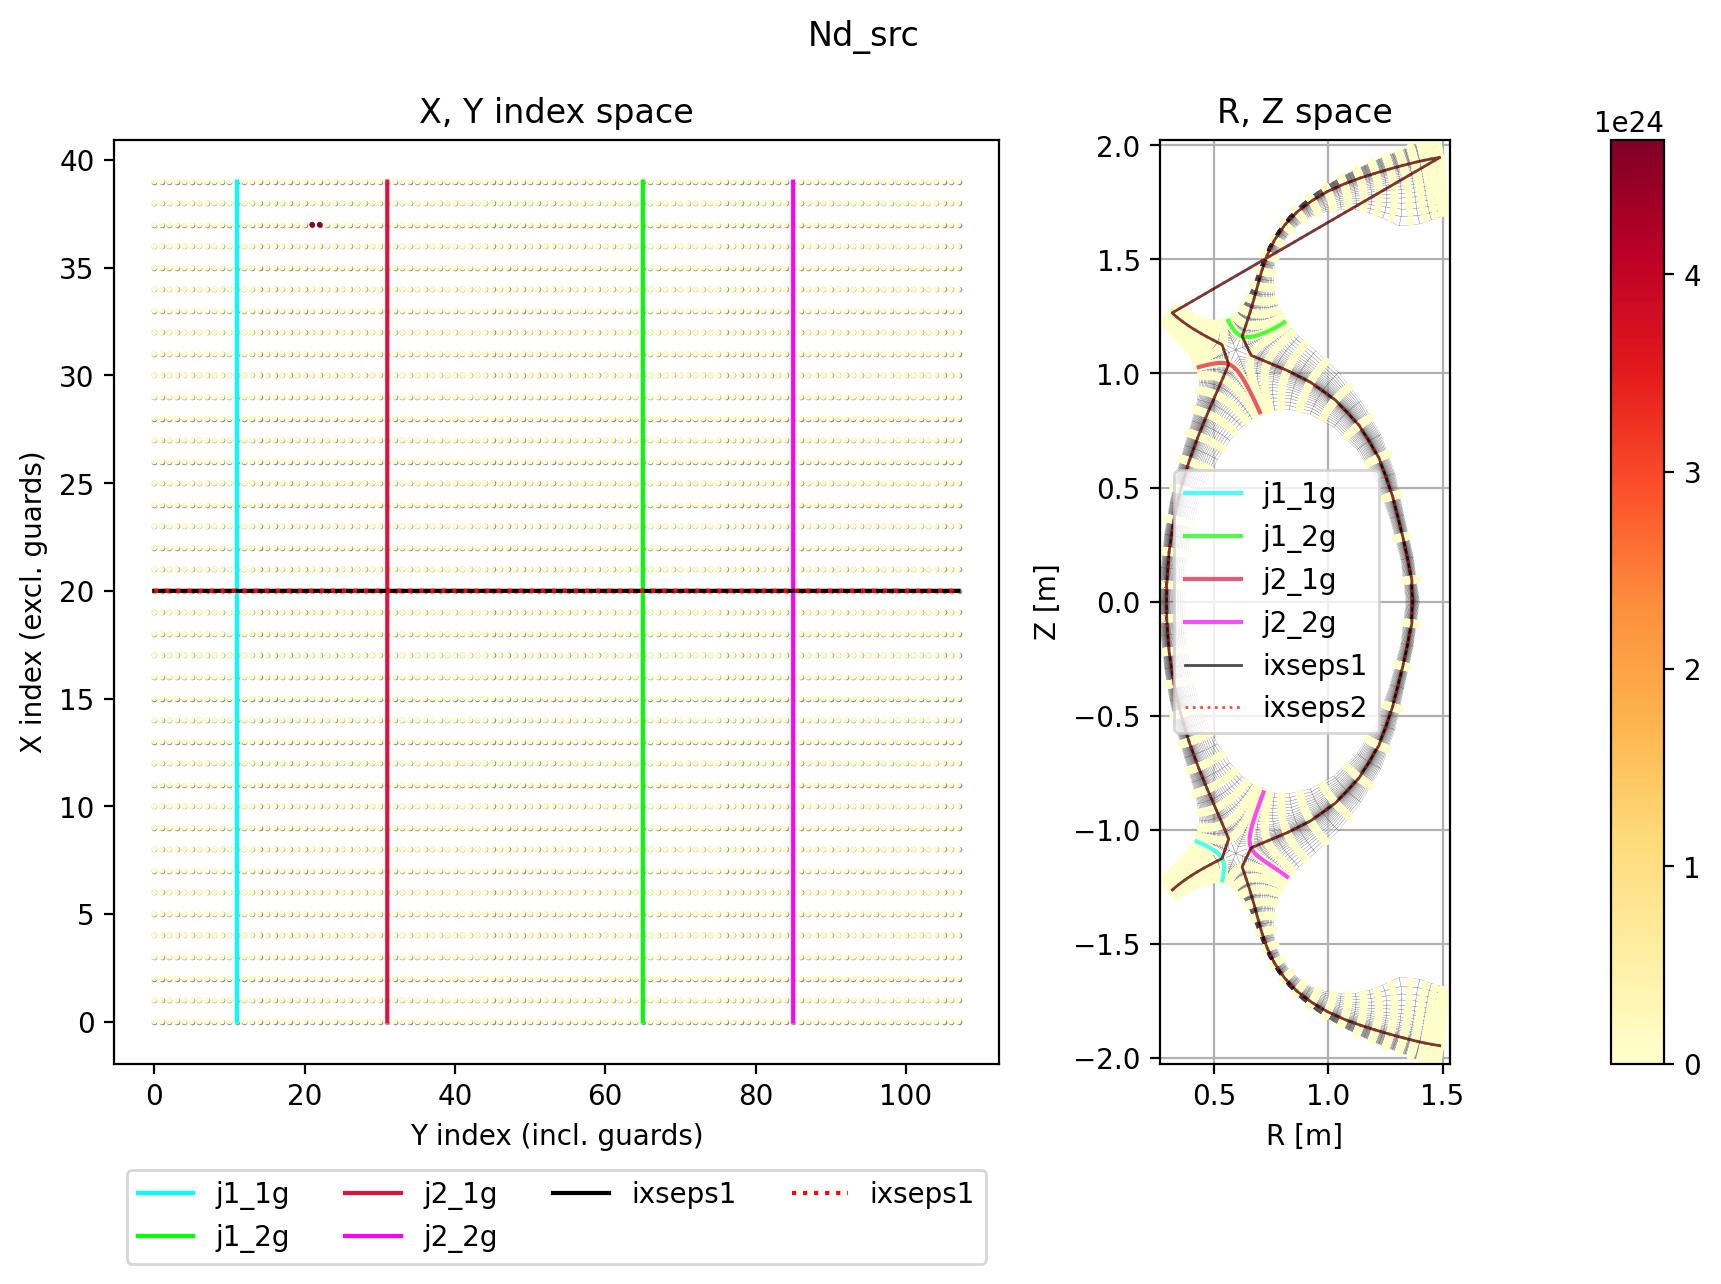

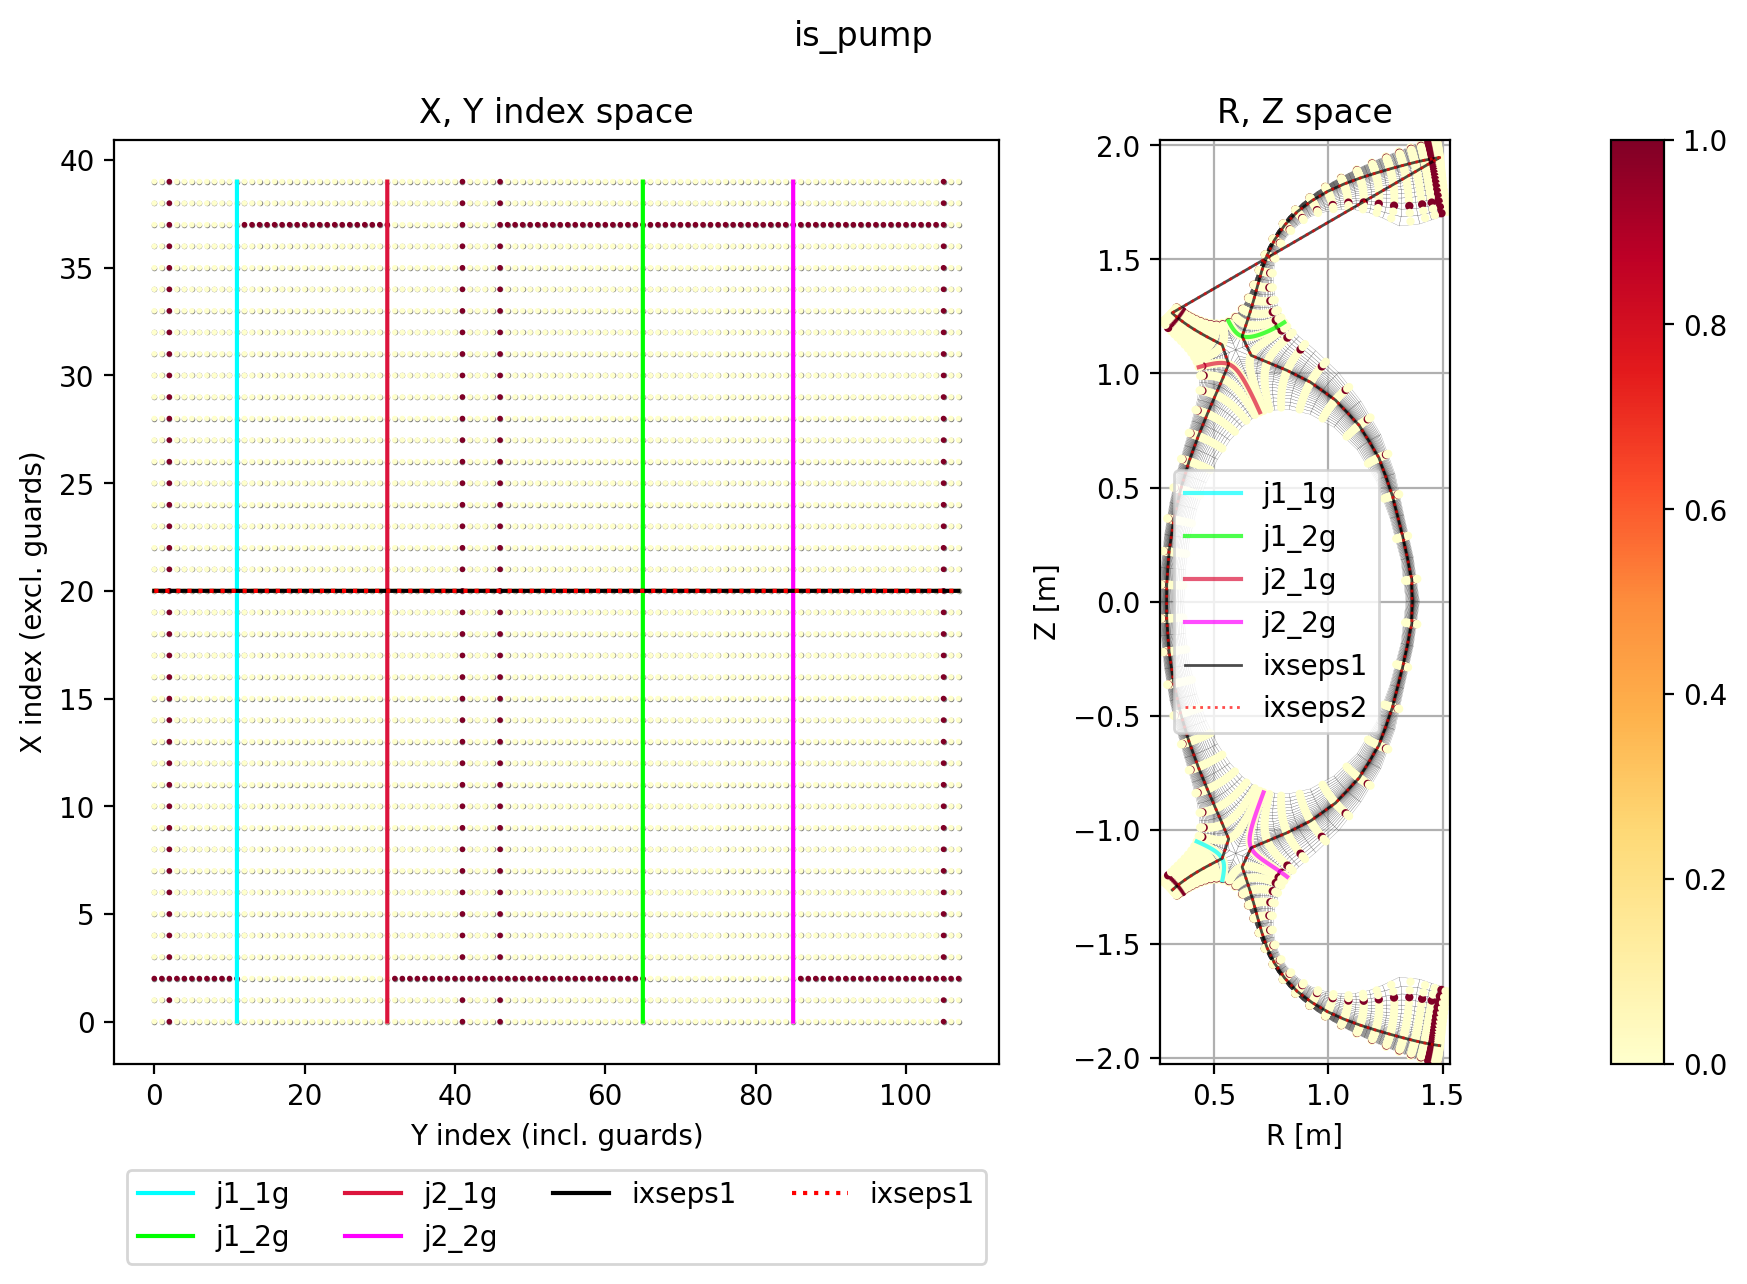

In [12]:
puff_rate = 5e21
pump_rate = -6e21  # -9.62e21


plt.close("all")
# new_grid_path = r"C:\Users\mikek\OneDrive\Project\collab\tech\grid\MAST-U\mu1af1-coresrc_puff.nc"

plt.close("all")
mesh = Mesh(new_grid_path)
self = mesh

midplane_a = int((self.j2_2g - self.j1_2g) / 2) + self.j1_2g
midplane_b = int((self.j2_2g - self.j1_2g) / 2) + self.j1_2g + 1

imp_a = int((self.j2_1g - self.j1_1g) / 2) + self.j1_1g + 1
imp_b = int((self.j2_1g - self.j1_1g) / 2) + self.j1_1g


# puff_indices = [2, 5, 8]   # fine grid
puff_indices = [1, 2, 3]   # SOLEDGE puff, coarse grid

selection =  (-self.MXG-1, 
            np.r_[
                imp_a,
                imp_b
                ])
            
# puff_region = mesh.slices("symmetric_puff")(width=3, center_half_gap=1)
puff_region = selection

mesh.mesh["dv"] = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi
volume = mesh.mesh["dv"][puff_region]

total_flow = puff_rate   # atoms per second

total_flow_per_volume = total_flow * (volume/volume.sum()) / volume  # first find how much per cell, then per volume
# print(f"Total flow: {total_flow} [s-1]")
# print(f"Total flow per volume: {total_flow_per_volume.sum():.2e} [s-1 m-3]")

heat_source = puff_rate * 3 * 2/3 * constants("q_e")  #  3eV per particle (assume dissociated molecules)
heat_source_per_volume = heat_source * (volume/volume.sum()) / volume 
# print(f"Total heat source: {heat_source:.2e} [W]")
# print(f"Total heat source per volume: {heat_source_per_volume.sum():.2e} [W m-3]")


Pd_src = Field("Pd_src", mesh)
Nd_src = Field("Nd_src", mesh)
is_pump = Field("is_pump", mesh)

print()

Nd_src.data[puff_region] = total_flow_per_volume
Pd_src.data[puff_region] = heat_source_per_volume

####################
# Divertor pump
####################
last_final = mesh.nyg - mesh.MYG-1
breakpoint = mesh.ny_inner + mesh.MYG*3
sel_divpump_lower = (-mesh.MXG-1, slice(last_final-1, last_final+1) )
sel_divpump_upper = (-mesh.MXG-1, slice(breakpoint, breakpoint+2) )

mesh.mesh["dv"] = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi

vol_divpump_upper = mesh.mesh["dv"][sel_divpump_upper].sum()
vol_divpump_lower = mesh.mesh["dv"][sel_divpump_lower].sum()
vol_divpump = vol_divpump_lower + vol_divpump_upper

pf_divpump = pump_rate # From SOLPS estimation
# Assume pumped neutrals are at 1eV
hf_divpump = pf_divpump * 1 * 2/3 * constants("q_e") 

# Sources
ps_divpump = pf_divpump / vol_divpump
hs_divpump = hf_divpump / vol_divpump

for loc in [sel_divpump_lower, sel_divpump_upper]:
    Nd_src.data[loc] = ps_divpump
    Pd_src.data[loc] = hs_divpump
    
##### CHECK

pf_tot = (Nd_src.data * mesh.mesh["dv"]).sum()
print(f"Total particle flow: {pf_tot:.2e} [s-1]")

#####
# SAVE
####

mesh.write_field(Nd_src)
mesh.write_field(Pd_src)

#####
# PUMP
####

is_pump.data[mesh.slices("inner_lower_target")] = 1
is_pump.data[mesh.slices("inner_upper_target")] = 1
is_pump.data[mesh.slices("outer_lower_target")] = 1
is_pump.data[mesh.slices("outer_upper_target")] = 1
is_pump.data[mesh.slices("sol_edge")] = 1
is_pump.data[mesh.slices("pfr_edge")] = 1

Nd_src.plot(dpi = 200)
is_pump.plot(dpi = 200)

mesh.write_field(is_pump, dtype = "Field2D")

try:
    mesh.close()
    del mesh
except:
    pass

In [21]:
try:
    mesh.close()
    del mesh
except:
    pass

mesh = Mesh(r"C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af7-divertor_pump.nc")

pressure_source_per_volume = mesh.mesh["Pe_src"].squeeze()
density_source_per_volume = mesh.mesh["Nd_src"].squeeze()

dv = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi

pressure_source = (pressure_source_per_volume * dv).sum()
density_source = (density_source_per_volume * dv).sum()

print(f"Total pressure source: {pressure_source:.2e} [Pa/s]")
print(f"Pressure source per volume: {pressure_source_per_volume.sum():.2e} [Pa/s m-3]")
print(f"Total density source: {density_source:.2e} [s-1]")
print(f"Density source per volume: {density_source_per_volume.sum():.2e} [s-1 m-3]")

try:
    mesh.close()
    del mesh
except:
    pass

Total pressure source: 0.00e+00 [Pa/s]
Pressure source per volume: 0.00e+00 [Pa/s m-3]
Total density source: -8.12e+21 [s-1]
Density source per volume: 1.46e+24 [s-1 m-3]
Mesh file C:\Users\Mike\OneDrive\Project\collab\tech\grid\MAST-U\mu1af7-divertor_pump.nc closed
